In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [ ]:
X_train = np.loadtxt('train_X.csv', delimiter = ',').T
Y_train = np.loadtxt('train_label.csv', delimiter = ',').T

X_test = np.loadtxt('test_X.csv', delimiter = ',').T
Y_test = np.loadtxt('test_label.csv', delimiter = ',').T

In [ ]:
print("shape of X_train :", X_train.shape)
print("shape of Y_train :", Y_train.shape)
print("shape of X_test :", X_test.shape)
print("shape of Y_test :", Y_test.shape)

shape of X_train : (784, 1000)
shape of Y_train : (10, 1000)
shape of X_test : (784, 350)
shape of Y_test : (10, 350)


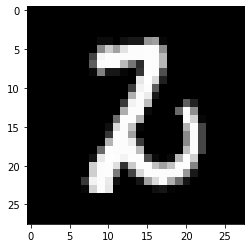

In [ ]:
index = random.randrange(0, X_train.shape[1])
plt.imshow(X_train[:, index].reshape(28, 28), cmap = 'gray')
plt.show()

In [ ]:
def tanh(x):
    return np.tanh(x)

def relu(x):
    return np.maximum(x, 0)
def sigmoid(x):
    clipped_x = np.clip(x, -500, 500)  # Clip x to avoid overflow
    return 1 / (1 + np.exp(-clipped_x))
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=0, keepdims=True))
    return exp_x / np.sum(exp_x, axis=0, keepdims=True)


In [ ]:
def derivative_sigmoid(x):
    sig_x = sigmoid(x)
    return sig_x * (1 - sig_x)

def derivative_relu(x):
    return np.array(x > 0, dtype = np.float32)

In [ ]:
def initialize_parameters(n_x, n_h, n_y):
    w1 = np.random.randn(n_h, n_x)*0.01
    b1 = np.zeros((n_h, 1))

    w2 = np.random.randn(n_y, n_h)*0.01
    b2 = np.zeros((n_y, 1))

    parameters = {
        "w1" : w1,
        "b1" : b1,
        "w2" : w2,
        "b2" : b2
    }

    return parameters

In [ ]:
def forward_propagation(x, parameters):

    w1 = parameters['w1']
    b1 = parameters['b1']
    w2 = parameters['w2']
    b2 = parameters['b2']

    z1 = np.dot(w1, x) + b1
    a1 = sigmoid(z1)

    z2 = np.dot(w2, a1) + b2
    a2 = softmax(z2)

    forward_cache = {
        "z1" : z1,
        "a1" : a1,
        "z2" : z2,
        "a2" : a2
    }

    return forward_cache

In [ ]:
def cost_function(a2, y):
    m = y.shape[1]

    # Avoiding division by zero in case of numerical instability
    epsilon = 1e-15
    a2 = np.clip(a2, epsilon, 1 - epsilon)

    cost = -(1/m) * np.sum(y * np.log(a2))

    return cost


In [ ]:
def backward_prop(x, y, parameters, forward_cache):

    w1 = parameters['w1']
    b1 = parameters['b1']
    w2 = parameters['w2']
    b2 = parameters['b2']

    a1 = forward_cache['a1']
    a2 = forward_cache['a2']

    m = x.shape[1]

    dz2 = (a2 - y)
    dw2 = (1/m)*np.dot(dz2, a1.T)
    db2 = (1/m)*np.sum(dz2, axis = 1, keepdims = True)

    dz1 = (1/m)*np.dot(w2.T, dz2)*derivative_sigmoid(a1)
    dw1 = (1/m)*np.dot(dz1, x.T)
    db1 = (1/m)*np.sum(dz1, axis = 1, keepdims = True)

    gradients = {
        "dw1" : dw1,
        "db1" : db1,
        "dw2" : dw2,
        "db2" : db2
    }

    return gradients

In [ ]:
def initialize_velocity(parameters):


    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}

    # Initialize velocity
    for l in range(L):
        ### START CODE HERE ### (approx. 2 lines)
        v["dw" + str(l + 1)] = np.zeros_like(parameters["w" + str(l+1)])
        v["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l+1)])
        ### END CODE HERE ###

    return v

In [ ]:
def update_parameters_with_momentum(parameters, grads, learning_rate, v, beta) :

    L = len(parameters) // 2 # number of layers in the neural networks

    # Momentum update for each parameter
    for l in range(L):

        # compute velocities
        v['dw' + str(l + 1)] = beta * v['dw' + str(l + 1)] +  grads['dw' + str(l + 1)]
        v['db' + str(l + 1)] = beta * v['db' + str(l + 1)] +  grads['db' + str(l + 1)]
        # update parameters
        parameters["w" + str(l + 1)] = parameters["w" + str(l + 1)] - learning_rate * v['dw' + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * v['db' + str(l + 1)]

    return parameters,v

In [ ]:
def initialize_adam(parameters) :
    L = len(parameters) //2  # number of layers in the neural networks
    v = {}
    s = {}


    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(L):
    ### START CODE HERE ### (approx. 4 lines)
        v["dw" + str(l + 1)] = np.zeros_like(parameters["w" + str(l + 1)])
        v["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])

        s["dw" + str(l+1)] = np.zeros_like(parameters["w" + str(l + 1)])
        s["db" + str(l+1)] = np.zeros_like(parameters["b" + str(l + 1)])
    ### END CODE HERE ###

    return v, s

In [ ]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate=0.01,
                                beta1=0.9, beta2=0.999, epsilon=1e-8):

    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    for l in range(L):
        # Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".
        v["dw" + str(l + 1)] = beta1 * v["dw" + str(l + 1)] + (1 - beta1) * grads['dw' + str(l + 1)]
        v["db" + str(l + 1)] = beta1 * v["db" + str(l + 1)] + (1 - beta1) * grads['db' + str(l + 1)]

        # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".
        v_corrected["dw" + str(l + 1)] = v["dw" + str(l + 1)] / (1 - np.power(beta1, t))
        v_corrected["db" + str(l + 1)] = v["db" + str(l + 1)] / (1 - np.power(beta1, t))

        # Moving average of the squared gradients. Inputs: "s, grads, beta2". Output: "s".
        s["dw" + str(l + 1)] = beta2 * s["dw" + str(l + 1)] + (1 - beta2) * np.power(grads['dw' + str(l + 1)], 2)
        s["db" + str(l + 1)] = beta2 * s["db" + str(l + 1)] + (1 - beta2) * np.power(grads['db' + str(l + 1)], 2)

        # Compute bias-corrected second raw moment estimate. Inputs: "s, beta2, t". Output: "s_corrected".
        s_corrected["dw" + str(l + 1)] = s["dw" + str(l + 1)] / (1 - np.power(beta2, t))
        s_corrected["db" + str(l + 1)] = s["db" + str(l + 1)] / (1 - np.power(beta2, t))
        parameters["w" + str(l + 1)] = parameters["w" + str(l + 1)] - learning_rate * v_corrected["dw" + str(l + 1)] / np.sqrt(s["dw" + str(l + 1)] + epsilon)
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * v_corrected["db" + str(l + 1)] / np.sqrt(s["db" + str(l + 1)] + epsilon)

    return parameters, v, s

In [ ]:
def initialize_rms(parameters) :
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    for l in range(L):
        v["dw" + str(l + 1)] = np.zeros_like(parameters["w" + str(l + 1)])
        v["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])

    return v

In [ ]:
def update_parameters_with_rms(parameters, grads, v, learning_rate=0.01,
                                beta1=0.9, epsilon=1e-8):
    L = len(parameters) // 2                 # number of layers in the neural networks
    for l in range(L):



      v["dw" + str(l + 1)] = beta1 * v["dw" + str(l + 1)] + (1 - beta1) * np.power(grads['dw' + str(l + 1)], 2)
      v["db" + str(l + 1)] = beta1 * v["db" + str(l + 1)] + (1 - beta1) * np.power(grads['db' + str(l + 1)], 2)

      parameters["w" + str(l + 1)] = parameters["w" + str(l + 1)] - learning_rate * grads['dw' + str(l + 1)] / np.sqrt(v["dw" + str(l + 1)] + epsilon)
      parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * grads['db' + str(l + 1)] / np.sqrt(v["db" + str(l + 1)] + epsilon)


    return parameters,v


In [ ]:
def initialize_adagrad(parameters) :
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    for l in range(L):
        v["dw" + str(l + 1)] = np.zeros_like(parameters["w" + str(l + 1)])
        v["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])

    return v

In [ ]:
def update_parameters_with_adagrad(parameters, grads, v, learning_rate=0.01,
                                beta1=0.9, epsilon=1e-8):
    L = len(parameters) // 2                 # number of layers in the neural networks
    for l in range(L):



      v["dw" + str(l + 1)] =  v["dw" + str(l + 1)] + np.power(grads['dw' + str(l + 1)], 2)
      v["db" + str(l + 1)] = v["db" + str(l + 1)] +  np.power(grads['db' + str(l + 1)], 2)

      parameters["w" + str(l + 1)] = parameters["w" + str(l + 1)] - learning_rate * grads['dw' + str(l + 1)] / np.sqrt(v["dw" + str(l + 1)] + epsilon)
      parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * grads['db' + str(l + 1)] / np.sqrt(v["db" + str(l + 1)] + epsilon)


    return parameters,v

# Complete Model

In [ ]:
def model(x, y, n_h,optimizer, learning_rate, iterations, beta=0.9,beta1=0.9, beta2=0.999, epsilon=1e-8,):
    n_x = x.shape[0]
    n_y = y.shape[0]

    cost_list = []
    t=0
    parameters = initialize_parameters(n_x, n_h, n_y)#returns w1,b1,w2,b2
    if optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    elif optimizer == "rms":
        v=initialize_rms(parameters)
    elif optimizer == "adagrad":
        v=initialize_adagrad(parameters)
    for i in range(iterations):

        forward_cache = forward_propagation(x, parameters)

        cost = cost_function(forward_cache['a2'], y)

        gradients = backward_prop(x, y, parameters, forward_cache)

        if optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, gradients, learning_rate, v, beta)
        elif optimizer == "adam":
                t = t + 1 # Adam counter
                parameters, v, s = update_parameters_with_adam(parameters, gradients, v, s,t, learning_rate, beta1, beta2,  epsilon)
        elif optimizer == "rms":
                parameters,v=update_parameters_with_rms(parameters, gradients, v, learning_rate, beta1,  epsilon)
        elif optimizer == "adagrad":
                parameters,v=update_parameters_with_rms(parameters, gradients, v, learning_rate,  epsilon)


        cost_list.append(cost)

        if(i%(iterations/10) == 0):
            print("Cost after", i, "iterations is :", cost)

    return parameters, cost_list

In [ ]:
iterations = 100
n_h = 128
learning_rate = 0.3
Parameters, Cost_list = model(X_train, Y_train, n_h = n_h,optimizer="momentum", learning_rate = learning_rate, iterations = iterations,beta=0.9)

Cost after 0 iterations is : 2.3018820315543107
Cost after 10 iterations is : 0.6972971750585054
Cost after 20 iterations is : 0.36179515545939256
Cost after 30 iterations is : 0.2618211401455697
Cost after 40 iterations is : 0.20253910659648486
Cost after 50 iterations is : 0.1779211937183356
Cost after 60 iterations is : 0.15916703270088328
Cost after 70 iterations is : 0.14592397917611782
Cost after 80 iterations is : 0.1417404784920282
Cost after 90 iterations is : 0.13490419565755066


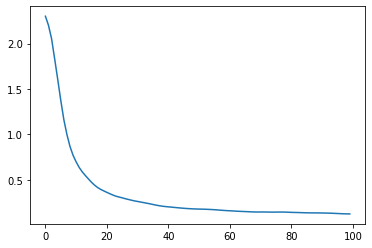

In [ ]:
t = np.arange(0, iterations)
plt.plot(t, Cost_list)
plt.show()

In [ ]:
def accuracy(inp, labels, parameters):
    forward_cache = forward_propagation(inp, parameters)
    a_out = forward_cache['a2']   # containes propabilities with shape(10, 1)

    a_out = np.argmax(a_out, 0)  # 0 represents row wise

    labels = np.argmax(labels, 0)

    acc = np.mean(a_out == labels)*100

    return acc

In [ ]:
print("Accuracy of Train Dataset", accuracy(X_train, Y_train, Parameters), "%")
print("Accuracy of Test Dataset", round(accuracy(X_test, Y_test, Parameters), 2), "%")

Accuracy of Train Dataset 97.8 %
Accuracy of Test Dataset 84.57 %


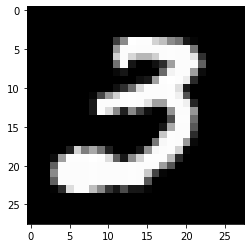

it is : 3


In [ ]:
idx = int(random.randrange(0,X_test.shape[1]))
plt.imshow(X_test[:, idx].reshape((28,28)),cmap='gray')
plt.show()

cache = forward_propagation(X_test[:, idx].reshape(X_test[:, idx].shape[0], 1), Parameters)
a_pred = cache['a2']
a_pred = np.argmax(a_pred, 0)

print("it is :", a_pred[0])